# Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer

# Read Data

In [2]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Data Understanding

Dataset ini berisi informasi terkait biaya klaim asuransi kesehatan individu. Setiap baris mewakili satu individu dengan atribut sebagai berikut:

* `age`: usia tertanggung (numerik)
* `sex`: jenis kelamin (`male` atau `female`)
* `bmi`: body mass index (numerik)
* `children`: jumlah anak yang ditanggung (numerik)
* `smoker`: status merokok (`yes` atau `no`)
* `region`: wilayah tempat tinggal (`southeast`, `southwest`, `northeast`, `northwest`)
* `charges`: total biaya asuransi yang ditagihkan (target variabel, numerik)

In [4]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(1)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


* Total data: **1337 baris**, **7 kolom**
* Tidak terdapat missing values pada semua kolom.
* Kolom `sex`, `smoker`, dan `region` bertipe kategorikal dan perlu dilakukan encoding.

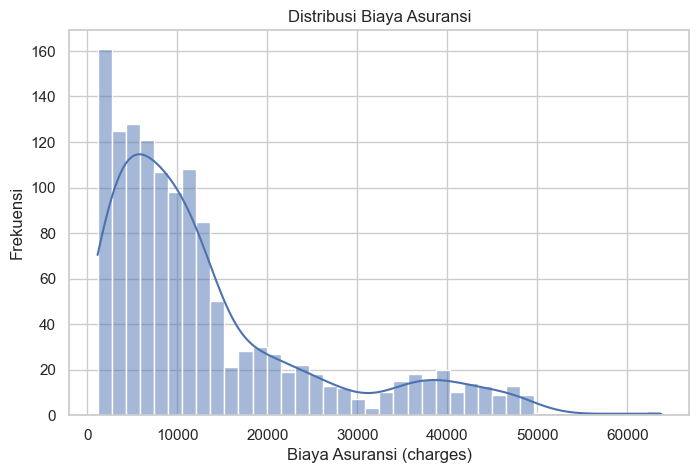

In [8]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.histplot(df['charges'], bins=40, kde=True)
plt.title("Distribusi Biaya Asuransi")
plt.xlabel("Biaya Asuransi (charges)")
plt.ylabel("Frekuensi")
plt.show()

Grafik di atas menunjukkan bahwa distribusi biaya asuransi (charges) bersifat right-skewed, artinya sebagian besar individu memiliki biaya yang relatif rendah, sementara sebagian kecil memiliki biaya sangat tinggi (outlier).

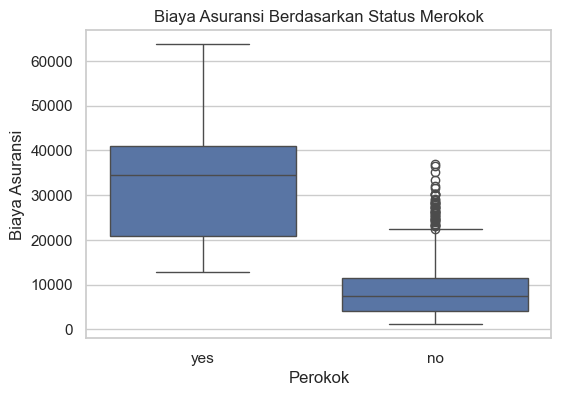

In [9]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="smoker", y="charges", data=df)
plt.title("Biaya Asuransi Berdasarkan Status Merokok")
plt.xlabel("Perokok")
plt.ylabel("Biaya Asuransi")
plt.show()


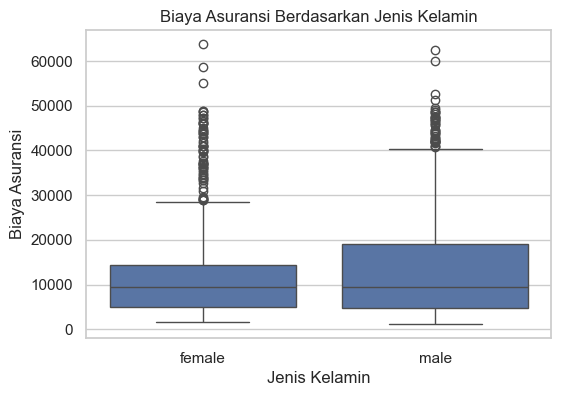

In [10]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="sex", y="charges", data=df)
plt.title("Biaya Asuransi Berdasarkan Jenis Kelamin")
plt.xlabel("Jenis Kelamin")
plt.ylabel("Biaya Asuransi")
plt.show()

Tidak ada perbedaan signifikan antara male dan female. Gender tampaknya tidak memiliki pengaruh besar terhadap biaya klaim

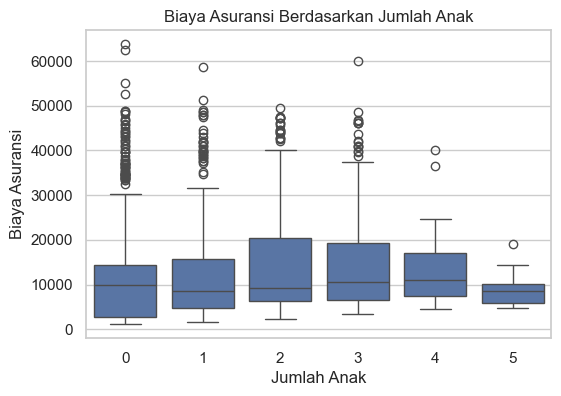

In [11]:
# Boxplot biaya asuransi berdasarkan jumlah anak
plt.figure(figsize=(6, 4))
sns.boxplot(x="children", y="charges", data=df)
plt.title("Biaya Asuransi Berdasarkan Jumlah Anak")
plt.xlabel("Jumlah Anak")
plt.ylabel("Biaya Asuransi")
plt.show()


Tidak ada pola konsisten. Median biaya hampir sama untuk semua kategori anak. Fitur children memiliki pengaruh rendah terhadap target variabel dan mungkin tidak terlalu penting.

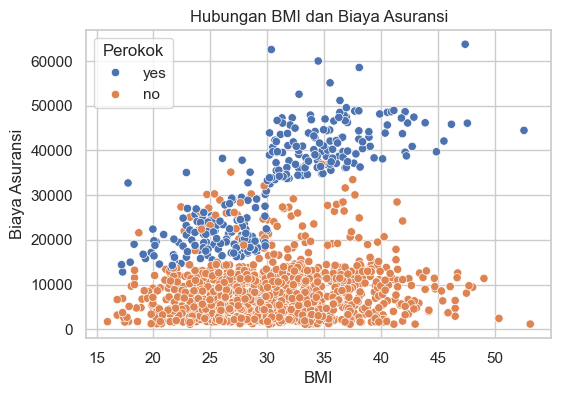

In [12]:

# Scatter plot BMI vs Charges
plt.figure(figsize=(6, 4))
sns.scatterplot(x="bmi", y="charges", hue="smoker", data=df)
plt.title("Hubungan BMI dan Biaya Asuransi")
plt.xlabel("BMI")
plt.ylabel("Biaya Asuransi")
plt.legend(title="Perokok")
plt.show()



Untuk non-perokok, hubungan BMI dan charges tidak terlalu kuat, Untuk perokok, terlihat pola bahwa semakin tinggi BMI, semakin tinggi biaya klaim. Ada interaksi antara variabel bmi dan smoker. Ini berpotensi dijadikan fitur interaksi dalam model.

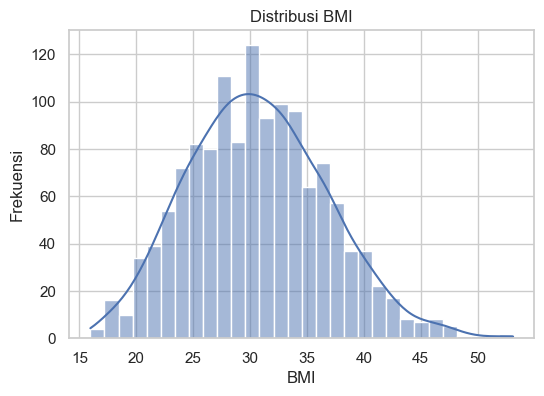

In [13]:
# Distribusi BMI
plt.figure(figsize=(6, 4))
sns.histplot(df['bmi'], bins=30, kde=True)
plt.title("Distribusi BMI")
plt.xlabel("BMI")
plt.ylabel("Frekuensi")
plt.show()

Mayoritas berada di rentang 25–35, menunjukkan bahwa sebagian besar peserta berada pada kondisi overweight. BMI dapat dijadikan indikator risiko dalam prediksi biaya kesehatan.

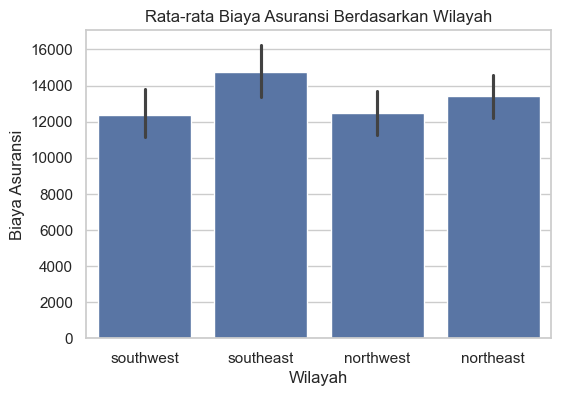

In [14]:
# Barplot rata-rata charges berdasarkan wilayah
plt.figure(figsize=(6, 4))
sns.barplot(x="region", y="charges", data=df)
plt.title("Rata-rata Biaya Asuransi Berdasarkan Wilayah")
plt.xlabel("Wilayah")
plt.ylabel("Biaya Asuransi")
plt.show()

Wilayah southeast memiliki rata-rata biaya tertinggi, sementara northeast dan northwest lebih rendah. Wilayah geografis dapat memengaruhi biaya asuransi (mungkin karena perbedaan biaya layanan kesehatan atau prevalensi penyakit).

# Data Preparation

In [15]:
region_le = LabelEncoder()
df['region'] = region_le.fit_transform(df['region'])

Bagian ini menggunakan LabelEncoder dari sklearn.preprocessing untuk mengubah nilai kategorikal pada kolom 'region' menjadi nilai numerik. Misalnya, jika ada 4 wilayah berbeda seperti 'southwest', 'southeast', 'northwest', dan 'northeast', masing-masing akan diubah menjadi angka seperti 0, 1, 2, dan 3. Label encoding digunakan di sini karena model machine learning tidak bisa langsung memproses data kategorikal dalam bentuk string.

In [16]:
y = df['charges']

Kode ini menetapkan kolom 'charges' sebagai variabel target (label) yang ingin diprediksi dalam model. Artinya, model nantinya akan mencoba mempelajari pola dari fitur-fitur lain untuk memprediksi nilai charges.

In [17]:
sex_ohe = OneHotEncoder(drop='first')
sex_encoded = sex_ohe.fit_transform(df[['sex']]).toarray()
sex_encoded_df = pd.DataFrame(sex_encoded, columns=sex_ohe.get_feature_names_out(['sex']))



Di bagian ini, kolom 'sex' yang berisi nilai kategorikal seperti 'male' dan 'female' diubah menjadi representasi numerik dengan menggunakan one-hot encoding. drop='first' digunakan agar salah satu kategori dibuang untuk menghindari dummy variable trap (redundansi data). Hasil encoding disimpan dalam bentuk array, lalu dikonversi menjadi DataFrame agar lebih mudah digabungkan kembali ke dataset.



In [18]:

# One-hot encode 'smoker'
smoker_ohe = OneHotEncoder(drop='first')
smoker_encoded = smoker_ohe.fit_transform(df[['smoker']]).toarray()
smoker_encoded_df = pd.DataFrame(smoker_encoded, columns=smoker_ohe.get_feature_names_out(['smoker']))

Bagian ini mirip dengan proses pada kolom 'sex', namun diterapkan pada kolom 'smoker'. Nilai 'yes' dan 'no' dikonversi menjadi bentuk numerik (0/1) menggunakan one-hot encoding, dengan satu nilai dibuang (drop='first') untuk menghindari kolinearitas antar fitur.

In [19]:
df_full = pd.concat([
    df.drop(['sex', 'smoker', 'charges'], axis=1).reset_index(drop=True),
    sex_encoded_df.reset_index(drop=True),
    smoker_encoded_df.reset_index(drop=True),
    y.reset_index(drop=True)
], axis=1)

Baris kode ini menggabungkan kembali semua komponen yang telah diproses menjadi satu DataFrame akhir bernama df_full. Kolom asli 'sex', 'smoker', dan 'charges' dihapus karena sudah digantikan oleh hasil one-hot encoding (sex_encoded_df dan smoker_encoded_df) dan target variabel y. Semua bagian disusun ulang index-nya (reset_index(drop=True)) agar sejajar saat digabung secara horizontal (axis=1). Hasil akhirnya adalah dataset siap pakai untuk pelatihan model.

In [20]:
correlation_result = df_full.corr(numeric_only=True)['charges'].sort_values(ascending=False)
correlation_result

charges       1.000000
smoker_yes    0.787234
age           0.298308
bmi           0.198401
children      0.067389
sex_male      0.058044
region       -0.006547
Name: charges, dtype: float64

In [21]:
df_full.head()

,age,bmi,children,region,sex_male,smoker_yes,charges
0,19,27.900,0,3,0.0,1.0,16884.92400
1,18,33.770,1,2,1.0,0.0,1725.55230
2,28,33.000,3,2,1.0,0.0,4449.46200
3,33,22.705,0,1,1.0,0.0,21984.47061
4,32,28.880,0,1,1.0,0.0,3866.85520


In [22]:
X = df_full.drop('charges', axis=1)
y = df_full['charges']

Baris ini memisahkan dataset df_full menjadi dua bagian: X sebagai fitur (semua kolom kecuali 'charges') dan y sebagai target yang ingin diprediksi (kolom 'charges'). Ini adalah langkah standar sebelum melakukan pelatihan model machine learning.

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Bagian ini melakukan normalisasi fitur X menggunakan StandardScaler, yang akan mengubah semua nilai fitur menjadi distribusi dengan rata-rata 0 dan standar deviasi 1. Tujuannya agar semua fitur berada pada skala yang sama, sehingga model tidak berat sebelah terhadap fitur dengan nilai yang lebih besar. Hasil transformasi disimpan dalam variabel X_scaled.

In [24]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled_df.head()

,age,bmi,children,region,sex_male,smoker_yes
0,-1.440418,-0.453160,-0.909234,1.343163,-1.009771,1.969660
1,-1.511647,0.509422,-0.079442,0.438017,0.990324,-0.507702
2,-0.799350,0.383155,1.580143,0.438017,0.990324,-0.507702
3,-0.443201,-1.305052,-0.909234,-0.467128,0.990324,-0.507702
4,-0.514431,-0.292456,-0.909234,-0.467128,0.990324,-0.507702


## Linear Regression Full Feature

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=123)

Baris ini membagi data menjadi data latih (X_train, y_train) dan data uji (X_test, y_test) dengan proporsi 80:20. Artinya, 80% data digunakan untuk melatih model, dan 20% sisanya untuk menguji performa model. Parameter random_state=123 digunakan agar hasil pembagian data tetap konsisten setiap kali kode dijalankan.

In [26]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=123),
    'Gradient Boosting': GradientBoostingRegressor(random_state=123)
}

Kode ini membuat sebuah dictionary bernama models yang berisi tiga jenis algoritma regresi yang akan digunakan untuk pelatihan dan evaluasi: Linear Regression, Random Forest Regressor, dan Gradient Boosting Regressor. Masing-masing model diinisialisasi, dan untuk Random Forest serta Gradient Boosting, ditetapkan random_state=123 agar hasil pelatihannya konsisten saat diulang.

In [27]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2 Score": r2_score(y_test, y_pred)
    }

results

{'Linear Regression': {'MAE': 3885.654597593016,
  'RMSE': np.float64(5560.282724554769),
  'R2 Score': 0.7999748183566514},
 'Random Forest': {'MAE': 2570.049896380367,
  'RMSE': np.float64(4228.546038606723),
  'R2 Score': 0.8843160655689203},
 'Gradient Boosting': {'MAE': 2351.9526093677705,
  'RMSE': np.float64(3851.460859721419),
  'R2 Score': 0.9040285842770742}}

## Linear Regression Numeric Feature

In [28]:
numerical_columns = ['age', 'bmi', 'children', 'region']
X_numerik_scaled = X_scaled_df[numerical_columns]

X_numerik_scaled.head()

,age,bmi,children,region
0,-1.440418,-0.453160,-0.909234,1.343163
1,-1.511647,0.509422,-0.079442,0.438017
2,-0.799350,0.383155,1.580143,0.438017
3,-0.443201,-1.305052,-0.909234,-0.467128
4,-0.514431,-0.292456,-0.909234,-0.467128


In [29]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_numerik_scaled, y, test_size=0.2, random_state=123)

In [30]:
for name, model in models.items():
    model.fit(X_train1, y_train1)
    y_pred1 = model.predict(X_test1)
    results[name] = {
        "MAE": mean_absolute_error(y_test1, y_pred1),
        "RMSE": np.sqrt(mean_squared_error(y_test1, y_pred1)),
        "R2 Score": r2_score(y_test1, y_pred1)
    }

results

{'Linear Regression': {'MAE': 9119.54983619394,
  'RMSE': np.float64(11641.194142501628),
  'R2 Score': 0.1232293806965804},
 'Random Forest': {'MAE': 9409.294112246607,
  'RMSE': np.float64(12539.381615070035),
  'R2 Score': -0.0172862234218234},
 'Gradient Boosting': {'MAE': 9048.543170949739,
  'RMSE': np.float64(11925.542773564492),
  'R2 Score': 0.07987414821816319}}

## Linear Regression Only Strong Correlation

In [31]:
X_strong_corr = X_scaled_df[['smoker_yes', 'age', 'bmi']]

X_strong_corr.head()


,smoker_yes,age,bmi
0,1.969660,-1.440418,-0.453160
1,-0.507702,-1.511647,0.509422
2,-0.507702,-0.799350,0.383155
3,-0.507702,-0.443201,-1.305052
4,-0.507702,-0.514431,-0.292456


In [32]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_numerik_scaled, y, test_size=0.2, random_state=123)

In [33]:
# Latih dan evaluasi setiap model
for name, model in models.items():
    model.fit(X_train2, y_train2)
    y_pred2 = model.predict(X_test2)
    results[name] = {
        "MAE": mean_absolute_error(y_test2, y_pred2),
        "RMSE": np.sqrt(mean_squared_error(y_test2, y_pred2)),
        "R2 Score": r2_score(y_test2, y_pred2)
    }

results

{'Linear Regression': {'MAE': 9119.54983619394,
  'RMSE': np.float64(11641.194142501628),
  'R2 Score': 0.1232293806965804},
 'Random Forest': {'MAE': 9409.294112246607,
  'RMSE': np.float64(12539.381615070035),
  'R2 Score': -0.0172862234218234},
 'Gradient Boosting': {'MAE': 9048.543170949739,
  'RMSE': np.float64(11925.542773564492),
  'R2 Score': 0.07987414821816319}}

### Interpretasi
1. Model terbaik adalah Gradient Boosting dengan semua fitur — jelas unggul di semua metrik (MAE, RMSE, R²).
2. Model dengan hanya fitur numerik atau korelasi kuat (yang sebenarnya juga numerik semua) gagal menangkap kompleksitas data → performanya jauh lebih buruk.
3. Performa model sangat bergantung pada informasi kategorikal, terutama smoker_yes, yang punya korelasi tinggi terhadap target.

# Prediction new Data

In [ ]:
best_model = GradientBoostingRegressor(random_state=123)
best_model.fit(X_train, y_train)
y_pred_new = best_model.predict(X_test)


array([ 4614.73872627, 12662.86906474, 16676.9512181 ,  3027.12341299,
       12975.91823648])

In [35]:
# Ubah array hasil prediksi ke DataFrame
y_pred_df = pd.DataFrame(y_pred_new, columns=['Predicted Charges'])
y_pred_df.head()


,Predicted Charges
0,4614.738726
1,12662.869065
2,16676.951218
3,3027.123413
4,12975.918236


In [36]:
comparison_df = pd.DataFrame({
    'Actual Charges': y_test.reset_index(drop=True),
    'Predicted Charges': y_pred_df['Predicted Charges']
})
comparison_df.head()

,Actual Charges,Predicted Charges
0,2775.19215,4614.738726
1,11538.42100,12662.869065
2,15817.98570,16676.951218
3,2007.94500,3027.123413
4,10564.88450,12975.918236


# Kesimpulan

Proyek ini bertujuan untuk membangun model prediktif guna memperkirakan biaya klaim asuransi kesehatan berdasarkan fitur demografi dan gaya hidup. Tiga pendekatan pemilihan fitur diuji: penggunaan seluruh fitur, fitur numerik saja, dan fitur dengan korelasi kuat terhadap target. Tiga model machine learning digunakan dalam evaluasi, yaitu Linear Regression, Random Forest, dan Gradient Boosting.

Hasil evaluasi menunjukkan bahwa pendekatan terbaik adalah menggunakan seluruh fitur yang telah melalui proses encoding dan scaling. Model Gradient Boosting memberikan performa terbaik dengan nilai MAE sebesar 2.351, RMSE sebesar 3.851, dan R² sebesar 0.904. Hal ini menunjukkan bahwa model dapat menjelaskan sekitar 90% variasi dalam data biaya klaim.

Sebaliknya, model yang hanya menggunakan fitur numerik atau fitur dengan korelasi tinggi (yang merupakan subset numerik) memberikan hasil yang jauh lebih buruk, baik dalam akurasi prediksi maupun kemampuan menjelaskan variasi data. Hal ini menegaskan pentingnya memasukkan fitur kategorikal, seperti status perokok, yang terbukti memiliki pengaruh besar terhadap prediksi biaya klaim.

Dengan demikian, model Gradient Boosting yang dilatih menggunakan seluruh fitur merupakan pilihan optimal untuk permasalahan regresi ini. Model ini mampu memberikan prediksi yang akurat dan stabil untuk mendukung pengambilan keputusan dalam sistem asuransi kesehatan.

